In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook has been created from the last iteration of 

  RunModel_Tracks_to_KDE_Testing_Skipper_14November2020_iter_1A
  
and has modified to
<ol>
    <li>  use a different loss function (kde_loss_Ba)</li>
    <li>  use much more training data (using Will's files)</li>
</ol>
    

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Feb 14 21:02:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 19%   35C    P0    32W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 250

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## Iter 2A ended with training cost = 3.94; validatin 3.7 - 3.8
folder = '14February_Skipper_iter2A2_250epochs_1em5_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_Skipper has 12 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_Skipper as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=59, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=59, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=59, out_features=4000, bias=True)


Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()


output =  ML/14February_Skipper_iter2A2_250epochs_1em5_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12.weight
index, k =   23    layer12.bias


In [14]:
##old_file = '15November_testing_Skipper_first_learning_iter_2A_1000epochs_1em5'
##old_file = '15November_testing_Skipper_first_learning_iter_2B_1000epochs_5em6'
##old_file = '15November_testing_Skipper_first_learning_iter_3B_1000epochs_3em6'
old_file = '14February_Skipper_2A_20epochs_1em5_4xwill'
old_name = old_file
iter_name = "final"
dict_name = "ML/" + old_file + "/" + old_name + "_" + iter_name + ".pyt"
pretrained_dict = torch.load(dict_name)


print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12.weight
index, k =   23    layer12.bias
pretrained_dict iterated


<All keys matched successfully>

In [15]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [16]:

## Training dataset. You can put as many files here as desired.

## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                  '/share/lazy/will/data/June30_2020_80k_2.h5',
                                  '/share/lazy/will/data/June30_2020_80k_3.h5',
                                  '/share/lazy/will/data/June30_2020_80k_4.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_5.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_6.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_7.h5',
                             batch_size=batch_size,
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            ##slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

nEvts =  80000
len(pocaMx[0]) =  196
len(pocaMx[1]) =  35
len(pocaMx[2]) =  265
len(pocaMx[3]) =  128
len(pocaMx[4]) =  124
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 196
 iEvt, nTrks =  1 35
 iEvt, nTrks =  2 265
 iEvt, nTrks =  3 128
 iEvt, nTrks =  4 124
 iEvt, nTrks =  5 122
 iEvt, nTrks =  6 300
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 243
 iEvt, nTrks =  9 112
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  -2.440992e-05
majorAxis[iTrk][1][0] =  -0.00038087237
majorAxis[iTrk][2][0] =  0.08211532
minorAxis_1[iTrk][0][0] =  -17.631672
minorAxis_1[iTrk][1][0] =  1.130005
minorAxis_1[iTrk][2][0] =  4.7444193e-08
minorAxis_2[iTrk][0][0] =  1.1299927
minorAxis_2[iTrk][1][0] =  17.631481
minorAxis_2[iTrk][2][0] =  0.08211532
  
majorAxis[iTrk][0][0] =  -0.02277395
majorAxis[iTrk][1][0] =  0.0014473597
majorAxis[iTrk][2][0] =  0.6347583
minorAxis_1[iTrk][0][0] =  -

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


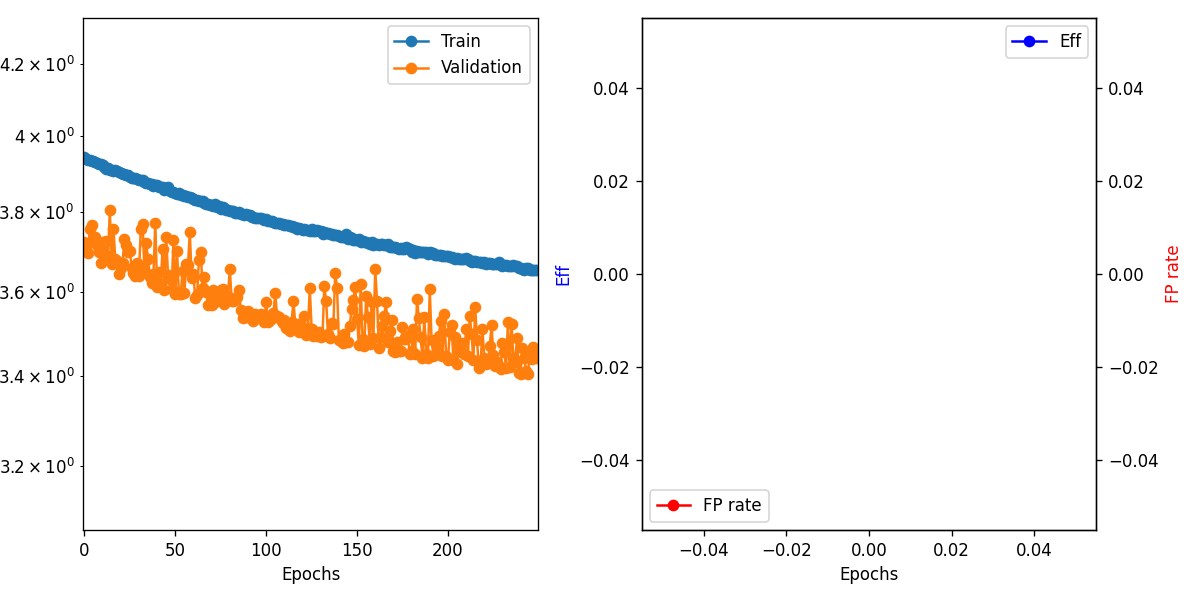

In [17]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [18]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 5000, val = 313


Number of batches: train = 5000, val = 313


Epoch 0: train=3.94415, val=3.72464, took 171.81 s


Epoch 1: train=3.93926, val=3.71417, took 168.73 s


Epoch 2: train=3.93642, val=3.69705, took 171.03 s


Epoch 3: train=3.93529, val=3.75587, took 166.27 s


Epoch 4: train=3.93357, val=3.76667, took 170.78 s


Epoch 5: train=3.93239, val=3.7314, took 168.04 s


Epoch 6: train=3.92986, val=3.73694, took 169.16 s


Epoch 7: train=3.92878, val=3.71684, took 162.35 s


Epoch 8: train=3.92664, val=3.69945, took 166.55 s


Epoch 9: train=3.92505, val=3.67067, took 168.4 s


Epoch 10: train=3.92304, val=3.72365, took 167.61 s


Epoch 11: train=3.91802, val=3.67828, took 167.81 s


Epoch 12: train=3.91322, val=3.72603, took 168.39 s


Epoch 13: train=3.91567, val=3.68768, took 166.08 s


Epoch 14: train=3.91028, val=3.80392, took 167.66 s


Epoch 15: train=3.90986, val=3.66738, took 174.91 s


Epoch 16: train=3.90749, val=3.75594, took 165.62 s


Epoch 17: train=3.90843, val=3.67962, took 167.27 s


Epoch 18: train=3.90704, val=3.67628, took 166.63 s


Epoch 19: train=3.90316, val=3.64388, took 168.05 s


Epoch 20: train=3.90033, val=3.65937, took 167.35 s


Epoch 21: train=3.89848, val=3.67209, took 171.42 s


Epoch 22: train=3.89808, val=3.72975, took 165.25 s


Epoch 23: train=3.89615, val=3.71561, took 168.55 s


Epoch 24: train=3.89525, val=3.69925, took 166.06 s


Epoch 25: train=3.89112, val=3.7012, took 169.29 s


Epoch 26: train=3.88872, val=3.65845, took 169.36 s


Epoch 27: train=3.88704, val=3.64655, took 165.97 s


Epoch 28: train=3.88946, val=3.63816, took 165.73 s


Epoch 29: train=3.88523, val=3.67176, took 166.69 s


Epoch 30: train=3.8818, val=3.63856, took 165.02 s


Epoch 31: train=3.88319, val=3.7557, took 167.41 s


Epoch 32: train=3.88196, val=3.76918, took 167.36 s


Epoch 33: train=3.87712, val=3.65616, took 165.97 s


Epoch 34: train=3.87506, val=3.72155, took 169.2 s


Epoch 35: train=3.87504, val=3.68114, took 170.46 s


Epoch 36: train=3.8737, val=3.63601, took 172.52 s


Epoch 37: train=3.87148, val=3.62187, took 167.93 s


Epoch 38: train=3.86692, val=3.64342, took 169.73 s


Epoch 39: train=3.86906, val=3.77271, took 167.82 s


Epoch 40: train=3.86972, val=3.61234, took 172.03 s


Epoch 41: train=3.86345, val=3.64754, took 174.84 s


Epoch 42: train=3.86583, val=3.6196, took 167.95 s


Epoch 43: train=3.86387, val=3.70506, took 165.25 s


Epoch 44: train=3.85806, val=3.60374, took 167.67 s


Epoch 45: train=3.85962, val=3.7359, took 168.67 s


Epoch 46: train=3.86364, val=3.6413, took 167.87 s


Epoch 47: train=3.85512, val=3.63035, took 168.28 s


Epoch 48: train=3.85284, val=3.60659, took 168.84 s


Epoch 49: train=3.85059, val=3.72967, took 167.69 s


Epoch 50: train=3.84911, val=3.59432, took 168.29 s


Epoch 51: train=3.84714, val=3.69995, took 166.65 s


Epoch 52: train=3.84794, val=3.59341, took 165.99 s


Epoch 53: train=3.84429, val=3.59412, took 163.0 s


Epoch 54: train=3.84432, val=3.6501, took 162.03 s


Epoch 55: train=3.84218, val=3.59609, took 168.5 s


Epoch 56: train=3.84033, val=3.66776, took 162.55 s


Epoch 57: train=3.83851, val=3.66681, took 166.42 s


Epoch 58: train=3.83857, val=3.74899, took 161.18 s


Epoch 59: train=3.83686, val=3.63326, took 161.37 s


Epoch 60: train=3.83308, val=3.64345, took 165.4 s


Epoch 61: train=3.83157, val=3.58397, took 163.83 s


Epoch 62: train=3.83052, val=3.59183, took 163.81 s


Epoch 63: train=3.82888, val=3.67781, took 160.94 s


Epoch 64: train=3.82729, val=3.69815, took 162.82 s


Epoch 65: train=3.8272, val=3.60823, took 163.71 s


Epoch 66: train=3.82304, val=3.63556, took 164.04 s


Epoch 67: train=3.82158, val=3.5999, took 163.45 s


Epoch 68: train=3.81922, val=3.5673, took 162.85 s


Epoch 69: train=3.81827, val=3.59655, took 162.97 s


Epoch 70: train=3.81833, val=3.5684, took 163.46 s


Epoch 71: train=3.81614, val=3.60357, took 172.59 s


Epoch 72: train=3.8194, val=3.57593, took 165.84 s


Epoch 73: train=3.81288, val=3.58566, took 169.1 s


Epoch 74: train=3.81425, val=3.5791, took 164.4 s


Epoch 75: train=3.80884, val=3.60486, took 165.83 s


Epoch 76: train=3.81261, val=3.60598, took 168.24 s


Epoch 77: train=3.8097, val=3.57074, took 162.08 s


Epoch 78: train=3.80534, val=3.59071, took 163.11 s


Epoch 79: train=3.80507, val=3.59053, took 164.03 s


Epoch 80: train=3.80194, val=3.65689, took 161.88 s


Epoch 81: train=3.80222, val=3.5788, took 168.4 s


Epoch 82: train=3.8027, val=3.57846, took 164.75 s


Epoch 83: train=3.79802, val=3.5804, took 165.58 s


Epoch 84: train=3.79817, val=3.58825, took 167.24 s


Epoch 85: train=3.79948, val=3.60352, took 162.03 s


Epoch 86: train=3.79486, val=3.55673, took 165.07 s


Epoch 87: train=3.79355, val=3.53739, took 161.87 s


Epoch 88: train=3.79256, val=3.54305, took 165.83 s


Epoch 89: train=3.79444, val=3.53802, took 162.43 s


Epoch 90: train=3.79194, val=3.55406, took 166.08 s


Epoch 91: train=3.79132, val=3.53616, took 164.1 s


Epoch 92: train=3.78668, val=3.54681, took 164.08 s


Epoch 93: train=3.78584, val=3.53017, took 166.34 s


Epoch 94: train=3.78523, val=3.54713, took 165.87 s


Epoch 95: train=3.78544, val=3.53796, took 167.76 s


Epoch 96: train=3.78458, val=3.53933, took 163.81 s


Epoch 97: train=3.78377, val=3.54741, took 162.39 s


Epoch 98: train=3.782, val=3.53205, took 164.03 s


Epoch 99: train=3.77971, val=3.52647, took 169.22 s


Epoch 100: train=3.78137, val=3.57464, took 167.47 s


Epoch 101: train=3.77548, val=3.52774, took 169.18 s


Epoch 102: train=3.77666, val=3.53172, took 167.76 s


Epoch 103: train=3.77721, val=3.53582, took 164.47 s


Epoch 104: train=3.77461, val=3.54753, took 169.3 s


Epoch 105: train=3.77144, val=3.59703, took 161.82 s


Epoch 106: train=3.77132, val=3.54046, took 160.2 s


Epoch 107: train=3.77138, val=3.53792, took 163.32 s


Epoch 108: train=3.76912, val=3.53219, took 158.57 s


Epoch 109: train=3.7701, val=3.52367, took 157.97 s


Epoch 110: train=3.76727, val=3.53118, took 158.31 s


Epoch 111: train=3.76543, val=3.51287, took 158.3 s


Epoch 112: train=3.76657, val=3.51056, took 157.97 s


Epoch 113: train=3.76365, val=3.50675, took 159.49 s


Epoch 114: train=3.76314, val=3.52621, took 158.88 s


Epoch 115: train=3.76181, val=3.5778, took 158.85 s


Epoch 116: train=3.76025, val=3.52219, took 158.7 s


Epoch 117: train=3.75754, val=3.52127, took 158.01 s


Epoch 118: train=3.75816, val=3.5034, took 158.22 s


Epoch 119: train=3.7568, val=3.51259, took 159.77 s


Epoch 120: train=3.75419, val=3.50721, took 158.74 s


Epoch 121: train=3.75535, val=3.54161, took 160.73 s


Epoch 122: train=3.75438, val=3.49725, took 161.42 s


Epoch 123: train=3.755, val=3.51284, took 158.5 s


Epoch 124: train=3.75014, val=3.60963, took 158.81 s


Epoch 125: train=3.75517, val=3.51125, took 158.46 s


Epoch 126: train=3.75102, val=3.49374, took 158.97 s


Epoch 127: train=3.75168, val=3.49505, took 162.48 s


Epoch 128: train=3.75309, val=3.49494, took 158.25 s


Epoch 129: train=3.75143, val=3.50273, took 158.98 s


Epoch 130: train=3.75104, val=3.49151, took 160.3 s


Epoch 131: train=3.74415, val=3.49368, took 162.1 s


Epoch 132: train=3.74861, val=3.61369, took 159.47 s


Epoch 133: train=3.74553, val=3.5774, took 160.4 s


Epoch 134: train=3.74604, val=3.49856, took 159.84 s


Epoch 135: train=3.74379, val=3.4899, took 159.63 s


Epoch 136: train=3.7431, val=3.52391, took 160.69 s


Epoch 137: train=3.74139, val=3.5214, took 158.85 s


Epoch 138: train=3.7408, val=3.64553, took 159.92 s


Epoch 139: train=3.74045, val=3.60943, took 160.68 s


Epoch 140: train=3.73803, val=3.48334, took 163.84 s


Epoch 141: train=3.73507, val=3.48286, took 162.32 s


Epoch 142: train=3.73554, val=3.47757, took 165.57 s


Epoch 143: train=3.73717, val=3.49898, took 162.54 s


Epoch 144: train=3.74322, val=3.48084, took 163.35 s


Epoch 145: train=3.73119, val=3.47871, took 164.09 s


Epoch 146: train=3.73606, val=3.51848, took 169.62 s


Epoch 147: train=3.73254, val=3.55848, took 167.71 s


Epoch 148: train=3.72824, val=3.58071, took 164.52 s


Epoch 149: train=3.72773, val=3.61188, took 164.33 s


Epoch 150: train=3.72897, val=3.53528, took 159.05 s


Epoch 151: train=3.72999, val=3.47206, took 158.34 s


Epoch 152: train=3.72428, val=3.61801, took 159.21 s


Epoch 153: train=3.727, val=3.48711, took 158.34 s


Epoch 154: train=3.72428, val=3.47093, took 160.57 s


Epoch 155: train=3.72286, val=3.58914, took 165.11 s


Epoch 156: train=3.72152, val=3.53941, took 161.76 s


Epoch 157: train=3.71908, val=3.47559, took 162.56 s


Epoch 158: train=3.72229, val=3.57601, took 161.09 s


Epoch 159: train=3.71599, val=3.48961, took 162.71 s


Epoch 160: train=3.71804, val=3.65578, took 159.36 s


Epoch 161: train=3.71801, val=3.5778, took 160.98 s


Epoch 162: train=3.7162, val=3.46578, took 158.9 s


Epoch 163: train=3.71843, val=3.4917, took 159.85 s


Epoch 164: train=3.71818, val=3.51812, took 158.25 s


Epoch 165: train=3.71684, val=3.54106, took 158.6 s


Epoch 166: train=3.71553, val=3.57516, took 158.62 s


Epoch 167: train=3.7177, val=3.4786, took 162.86 s


Epoch 168: train=3.71169, val=3.50588, took 163.34 s


Epoch 169: train=3.7107, val=3.53216, took 158.61 s


Epoch 170: train=3.71083, val=3.45762, took 158.86 s


Epoch 171: train=3.71125, val=3.45656, took 158.48 s


Epoch 172: train=3.70818, val=3.47865, took 158.36 s


Epoch 173: train=3.7064, val=3.45814, took 158.1 s


Epoch 174: train=3.70787, val=3.45826, took 158.3 s


Epoch 175: train=3.70593, val=3.51452, took 157.85 s


Epoch 176: train=3.70537, val=3.48757, took 159.27 s


Epoch 177: train=3.71018, val=3.48712, took 160.39 s


Epoch 178: train=3.7073, val=3.49393, took 158.05 s


Epoch 179: train=3.70513, val=3.45094, took 158.36 s


Epoch 180: train=3.69888, val=3.45857, took 159.12 s


Epoch 181: train=3.70367, val=3.5097, took 157.99 s


Epoch 182: train=3.69674, val=3.45269, took 161.85 s


Epoch 183: train=3.70144, val=3.58309, took 161.05 s


Epoch 184: train=3.69876, val=3.53565, took 158.49 s


Epoch 185: train=3.69827, val=3.4906, took 159.45 s


Epoch 186: train=3.69879, val=3.44233, took 158.51 s


Epoch 187: train=3.69711, val=3.53926, took 158.68 s


Epoch 188: train=3.6972, val=3.45043, took 158.63 s


Epoch 189: train=3.69241, val=3.44218, took 158.84 s


Epoch 190: train=3.69784, val=3.60645, took 158.23 s


Epoch 191: train=3.69522, val=3.48423, took 159.4 s


Epoch 192: train=3.69652, val=3.4466, took 161.73 s


Epoch 193: train=3.69203, val=3.44815, took 161.8 s


Epoch 194: train=3.69046, val=3.46744, took 160.3 s


Epoch 195: train=3.68963, val=3.49488, took 160.85 s


Epoch 196: train=3.69083, val=3.52912, took 162.37 s


Epoch 197: train=3.68809, val=3.44722, took 160.31 s


Epoch 198: train=3.688, val=3.54691, took 163.62 s


Epoch 199: train=3.68821, val=3.44791, took 159.67 s


Epoch 200: train=3.68901, val=3.43677, took 159.35 s


Epoch 201: train=3.68486, val=3.50416, took 160.21 s


Epoch 202: train=3.68649, val=3.52043, took 158.29 s


Epoch 203: train=3.6838, val=3.4372, took 158.94 s


Epoch 204: train=3.68169, val=3.49215, took 159.82 s


Epoch 205: train=3.68435, val=3.42889, took 159.41 s


Epoch 206: train=3.68012, val=3.45834, took 160.75 s


Epoch 207: train=3.67963, val=3.45588, took 158.5 s


Epoch 208: train=3.68167, val=3.47628, took 159.71 s


Epoch 209: train=3.68079, val=3.45231, took 159.77 s


Epoch 210: train=3.68219, val=3.51026, took 160.39 s


Epoch 211: train=3.68202, val=3.44762, took 158.82 s


Epoch 212: train=3.67663, val=3.5416, took 158.98 s


Epoch 213: train=3.6743, val=3.4978, took 158.75 s


Epoch 214: train=3.67701, val=3.43716, took 159.89 s


Epoch 215: train=3.67472, val=3.56209, took 160.46 s


Epoch 216: train=3.67425, val=3.48544, took 159.92 s


Epoch 217: train=3.67389, val=3.4189, took 160.79 s


Epoch 218: train=3.67227, val=3.43226, took 160.98 s


Epoch 219: train=3.67106, val=3.51067, took 158.47 s


Epoch 220: train=3.67439, val=3.44248, took 158.66 s


Epoch 221: train=3.6693, val=3.42722, took 157.87 s


Epoch 222: train=3.67021, val=3.42952, took 159.34 s


Epoch 223: train=3.67063, val=3.46941, took 162.73 s


Epoch 224: train=3.66774, val=3.51985, took 160.31 s


Epoch 225: train=3.66891, val=3.44822, took 160.75 s


Epoch 226: train=3.66925, val=3.4234, took 165.12 s


Epoch 227: train=3.66825, val=3.43366, took 163.81 s


Epoch 228: train=3.67269, val=3.42276, took 162.9 s


Epoch 229: train=3.66478, val=3.41595, took 163.79 s


Epoch 230: train=3.66375, val=3.47637, took 158.78 s


Epoch 231: train=3.66514, val=3.45567, took 158.35 s


Epoch 232: train=3.6657, val=3.41941, took 159.89 s


Epoch 233: train=3.66456, val=3.52771, took 159.22 s


Epoch 234: train=3.66262, val=3.42177, took 158.57 s


Epoch 235: train=3.66257, val=3.52158, took 159.53 s


Epoch 236: train=3.66627, val=3.44216, took 159.91 s


Epoch 237: train=3.66342, val=3.43327, took 160.0 s


Epoch 238: train=3.6625, val=3.48934, took 160.3 s


Epoch 239: train=3.65863, val=3.40772, took 160.2 s


Epoch 240: train=3.65964, val=3.40588, took 162.33 s


Epoch 241: train=3.6566, val=3.46505, took 161.06 s


Epoch 242: train=3.65375, val=3.44333, took 160.97 s


Epoch 243: train=3.65752, val=3.41124, took 159.32 s


Epoch 244: train=3.659, val=3.40407, took 159.67 s


Epoch 245: train=3.65418, val=3.45523, took 158.94 s


Epoch 246: train=3.65349, val=3.43984, took 159.5 s


Epoch 247: train=3.65236, val=3.46831, took 158.65 s


Epoch 248: train=3.65363, val=3.45035, took 158.87 s


Epoch 249: train=3.65392, val=3.44238, took 159.17 s



Go ahead and save the final model (even though it was also saved above):

In [19]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [20]:
results.to_hdf(str(output / f'{name}_stats_a.hdf5'),'results')

Save the plot above:

<IPython.core.display.Javascript object>


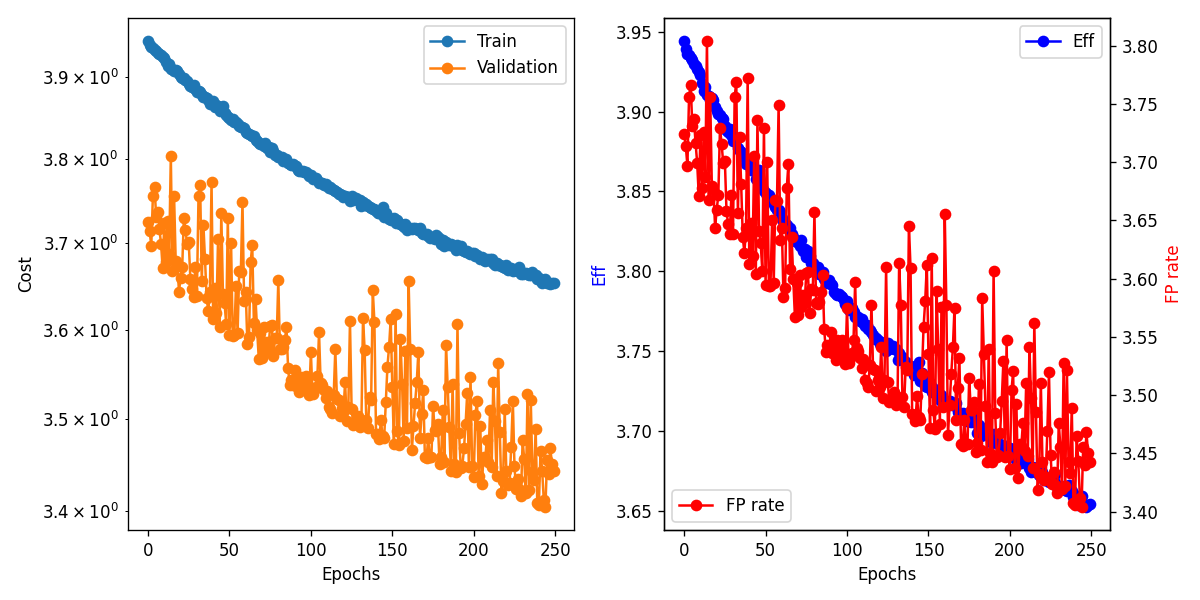

In [21]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [22]:
##quit()